# Data Statistics

In [1]:
import pickle
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

## 1 Loading pickled stats

In [6]:
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [7]:
dataset_names = ['taskonomy', 'replica', 'gso', 'hypersim', 'habitat2']
splits = ['train', 'val', 'test']
stats_dir = './omnidata_stats'

In [8]:
stats_dict = {}

for dataset_name in dataset_names:
    stats_dict[dataset_name] = {}
    for split in splits:
        if dataset_name == 'habitat2' and split == 'test':
            continue # Habitat doesn't have a test split
        rots_x = load_pickle(f'{stats_dir}/{dataset_name}-{split}-rots_x.pkl')
        rots_y = load_pickle(f'{stats_dir}/{dataset_name}-{split}-rots_y.pkl')
        rots_z = load_pickle(f'{stats_dir}/{dataset_name}-{split}-rots_z.pkl')
        fovs = load_pickle(f'{stats_dir}/{dataset_name}-{split}-fovs.pkl')
        distances = load_pickle(f'{stats_dir}/{dataset_name}-{split}-distances.pkl') if dataset_name != 'hypersim' else None
        obliqueness_angles = load_pickle(f'{stats_dir}/{dataset_name}-{split}-obliqueness_angles.pkl') if dataset_name != 'hypersim' else None
        points_in_views = load_pickle(f'{stats_dir}/{dataset_name}-{split}-points_in_views.pkl') if dataset_name != 'hypersim' else None
        views_per_point = load_pickle(f'{stats_dir}/{dataset_name}-{split}-views_per_point.pkl') if dataset_name != 'hypersim' else None
        points_per_camera = load_pickle(f'{stats_dir}/{dataset_name}-{split}-points_per_camera.pkl') if dataset_name != 'hypersim' else None
        cameras_per_point = load_pickle(f'{stats_dir}/{dataset_name}-{split}-cameras_per_point.pkl') if dataset_name != 'hypersim' else None
        
        stats_dict[dataset_name][split] = {
            'rots_x': rots_x,
            'rots_y': rots_y,
            'rots_z': rots_z,
            'fovs': fovs,
            'distances': distances,
            'obliqueness_angles': obliqueness_angles,
            'points_in_views': points_in_views,
            'views_per_point': views_per_point,
            'points_per_camera': points_per_camera,
            'cameras_per_point': cameras_per_point
        }

In [9]:
def get_stats(stats_dict, dataset_name, split_name, stat_name):
    if dataset_name not in stats_dict:
        return []
    if split_name not in stats_dict[dataset_name]:
        return []
    if stat_name not in stats_dict[dataset_name][split_name]:
        return []
    return stats_dict[dataset_name][split_name][stat_name]

## 2 Histograms of data statistics

In [82]:
COLORS = ['#599ec4', '#d65f3d', '#ecc363']

def get_dataset_prefix(dataset_name):
    dataset_prefix = ''
    if dataset_name == 'taskonomy':
        dataset_prefix = 'Taskonomy: '
    elif dataset_name == 'replica':
        dataset_prefix = 'Replica: '
    elif dataset_name == 'hypersim':
        dataset_prefix = 'Hypersim: '
    elif dataset_name == 'gso':
        dataset_prefix = 'Replica-GSO: '
    elif dataset_name == 'habitat2':
        dataset_prefix = 'Habitat 2: '
    return dataset_prefix

def plot_hist(train_list, val_list, test_list, bins, dataset_name, 
              title, xlabel, ylabel='Density',
              combine=False, save_path=None):
    plt.figure(figsize=(10,5))
    
    if combine:
        all_list = train_list + val_list + test_list
        plt.hist(all_list, bins=bins, density=True, color=COLORS[0], edgecolor='black')
    else:
        hist_lists, hist_labels, hist_colors = [], [], []
        if len(train_list) > 0:
            hist_lists.append(train_list)
            hist_labels.append('Train')
            hist_colors.append(COLORS[0])
        if len(val_list) > 0:
            hist_lists.append(val_list)
            hist_labels.append('Val')
            hist_colors.append(COLORS[1])
        if len(test_list) > 0:
            hist_lists.append(test_list)
            hist_labels.append('Test')
            hist_colors.append(COLORS[2])
        plt.hist(hist_lists, bins=bins, density=True, 
                 label=hist_labels, color=hist_colors, edgecolor='black')
        plt.legend(loc='upper right', fontsize=14, fancybox=False)
        
    dataset_prefix = get_dataset_prefix(dataset_name)
    plt.title(dataset_prefix + title, fontsize=18)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    else:
        plt.show()
        
def get_camera_pitch(stats_dict, dataset_name):
    stat_name = 'rots_x'
    train_list = get_stats(stats_dict, dataset_name, 'train', stat_name)
    val_list = get_stats(stats_dict, dataset_name, 'val', stat_name)
    test_list = get_stats(stats_dict, dataset_name, 'test', stat_name)
    
    train_list = [abs(rad) * 180/np.pi - 90 for rad in train_list]
    val_list = [abs(rad) * 180/np.pi - 90 for rad in val_list]
    test_list = [abs(rad) * 180/np.pi - 90 for rad in test_list]
    
    return train_list, val_list, test_list
        
def plot_camera_pitch(stats_dict, dataset_name, combine=False, save_path=None):
    train_list, val_list, test_list = get_camera_pitch(stats_dict, dataset_name)
    
    bins = 30
    title = 'Camera Pitch Histogram'
    xlabel = 'Camera Pitch [degrees]'
    
    plot_hist(train_list, val_list, test_list, bins, dataset_name, 
              title, xlabel, ylabel='Density',
              combine=combine, save_path=save_path)
    
def get_camera_roll(stats_dict, dataset_name):
    stat_name = 'rots_y'
    train_list = get_stats(stats_dict, dataset_name, 'train', stat_name)
    val_list = get_stats(stats_dict, dataset_name, 'val', stat_name)
    test_list = get_stats(stats_dict, dataset_name, 'test', stat_name)
    
    train_list = [rad * 180/np.pi for rad in train_list if rad < 1 and rad > -1]
    val_list = [rad * 180/np.pi for rad in val_list if rad < 1 and rad > -1]
    test_list = [rad * 180/np.pi for rad in test_list if rad < 1 and rad > -1]
    
    return train_list, val_list, test_list
        
def plot_camera_roll(stats_dict, dataset_name, combine=False, save_path=None):
    train_list, val_list, test_list = get_camera_roll(stats_dict, dataset_name)
    
    bins = 30
    title = 'Camera Roll Histogram'
    xlabel = 'Camera Roll [degrees]'
    
    plot_hist(train_list, val_list, test_list, bins, dataset_name, 
              title, xlabel, ylabel='Density',
              combine=combine, save_path=save_path)

def get_fovs(stats_dict, dataset_name):
    stat_name = 'fovs'
    train_list = get_stats(stats_dict, dataset_name, 'train', stat_name)
    val_list = get_stats(stats_dict, dataset_name, 'val', stat_name)
    test_list = get_stats(stats_dict, dataset_name, 'test', stat_name)
    
    train_list = [rad * 180/np.pi for rad in train_list]
    val_list = [rad * 180/np.pi for rad in val_list]
    test_list = [rad * 180/np.pi for rad in test_list]
    
    return train_list, val_list, test_list
    
def plot_fovs(stats_dict, dataset_name, combine=False, save_path=None):
    train_list, val_list, test_list = get_fovs(stats_dict, dataset_name)
    
    bins = 30
    title = 'Field of View Histogram'
    xlabel = 'Field of View [degrees]'
    
    plot_hist(train_list, val_list, test_list, bins, dataset_name, 
              title, xlabel, ylabel='Density',
              combine=combine, save_path=save_path)

def get_distances(stats_dict, dataset_name):
    stat_name = 'distances'
    train_list = get_stats(stats_dict, dataset_name, 'train', stat_name)
    val_list = get_stats(stats_dict, dataset_name, 'val', stat_name)
    test_list = get_stats(stats_dict, dataset_name, 'test', stat_name)
    
    return train_list, val_list, test_list
    
def plot_distances(stats_dict, dataset_name, combine=False, save_path=None):
    train_list, val_list, test_list = get_distances(stats_dict, dataset_name)
    
    bins = 30
    title = 'Distance to Scene Content Histogram'
    xlabel = 'Distance [meters]'
    
    plot_hist(train_list, val_list, test_list, bins, dataset_name, 
              title, xlabel, ylabel='Density',
              combine=combine, save_path=save_path)

def get_obliqueness_angles(stats_dict, dataset_name):
    stat_name = 'obliqueness_angles'
    train_list = get_stats(stats_dict, dataset_name, 'train', stat_name)
    val_list = get_stats(stats_dict, dataset_name, 'val', stat_name)
    test_list = get_stats(stats_dict, dataset_name, 'test', stat_name)
    
    train_list = [rad * 180/np.pi for rad in train_list]
    val_list = [rad * 180/np.pi for rad in val_list]
    test_list = [rad * 180/np.pi for rad in test_list]
    
    return train_list, val_list, test_list
    
def plot_obliqueness_angles(stats_dict, dataset_name, combine=False, save_path=None):
    train_list, val_list, test_list = get_obliqueness_angles(stats_dict, dataset_name)
    
    bins = 30
    title = '3D Obliqueness of Scene Content Histogram'
    xlabel = 'Obliqueness angle [degrees]'
    
    plot_hist(train_list, val_list, test_list, bins, dataset_name, 
              title, xlabel, ylabel='Density',
              combine=combine, save_path=save_path)
    
def get_points_per_camera(stats_dict, dataset_name):
    stat_name = 'points_per_camera'
    train_list = get_stats(stats_dict, dataset_name, 'train', stat_name)
    val_list = get_stats(stats_dict, dataset_name, 'val', stat_name)
    test_list = get_stats(stats_dict, dataset_name, 'test', stat_name)
    
    return train_list, val_list, test_list

def plot_points_per_camera(stats_dict, dataset_name, combine=False, save_path=None):
    train_list, val_list, test_list = get_points_per_camera(stats_dict, dataset_name)
    
    bins = 30
    title = 'Number of Points in View Histogram'
    xlabel = 'Count'
    
    plot_hist(train_list, val_list, test_list, bins, dataset_name, 
              title, xlabel, ylabel='Density',
              combine=combine, save_path=save_path)
    
def get_views_per_point(stats_dict, dataset_name):
    stat_name = 'views_per_point'
    train_list = get_stats(stats_dict, dataset_name, 'train', stat_name)
    val_list = get_stats(stats_dict, dataset_name, 'val', stat_name)
    test_list = get_stats(stats_dict, dataset_name, 'test', stat_name)
    
    return train_list, val_list, test_list
    
def plot_views_per_point(stats_dict, dataset_name, combine=False, save_path=None):
    train_list, val_list, test_list = get_views_per_point(stats_dict, dataset_name)
    
    max_views = np.max(train_list + val_list + test_list)
    if combine:
        bins = list(range(0,max_views))
    else:
        bins = list(range(0,max_views,2))
        
    title = 'Number of Views per Point Histogram'
    xlabel = 'Count'
    
    plot_hist(train_list, val_list, test_list, bins, dataset_name, 
              title, xlabel, ylabel='Density',
              combine=combine, save_path=save_path)
    
def get_cameras_per_point(stats_dict, dataset_name):
    stat_name = 'cameras_per_point'
    train_list = get_stats(stats_dict, dataset_name, 'train', stat_name)
    val_list = get_stats(stats_dict, dataset_name, 'val', stat_name)
    test_list = get_stats(stats_dict, dataset_name, 'test', stat_name)
    
    return train_list, val_list, test_list

def plot_cameras_per_point(stats_dict, dataset_name, combine=False, save_path=None):
    train_list, val_list, test_list = get_cameras_per_point(stats_dict, dataset_name)
    
    bins = 30
    title = 'Number of Cameras that Observe a Point Histogram'
    xlabel = 'Count'
    
    plot_hist(train_list, val_list, test_list, bins, dataset_name, 
              title, xlabel, ylabel='Density',
              combine=combine, save_path=save_path)

### 2.1 Camera Pitch

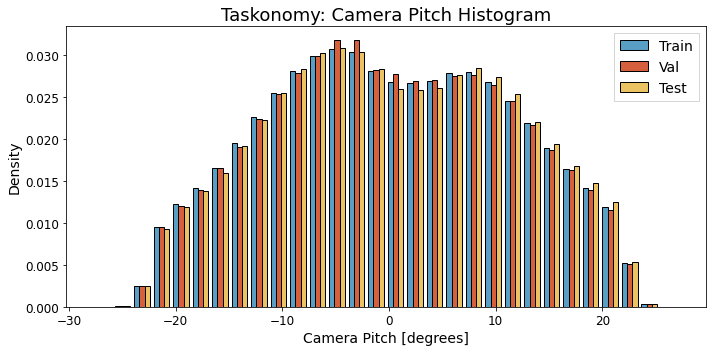

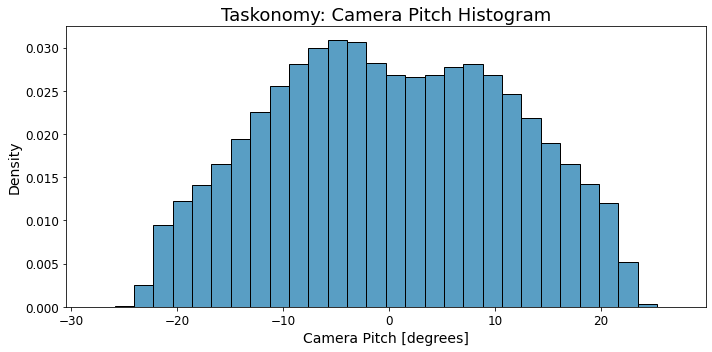

In [83]:
plot_camera_pitch(stats_dict, 'taskonomy', combine=False)
plot_camera_pitch(stats_dict, 'taskonomy', combine=True)

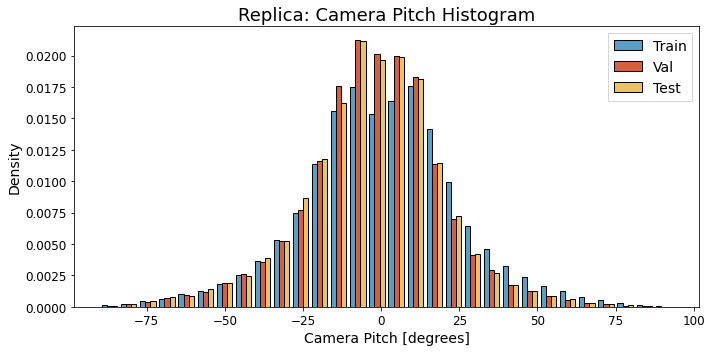

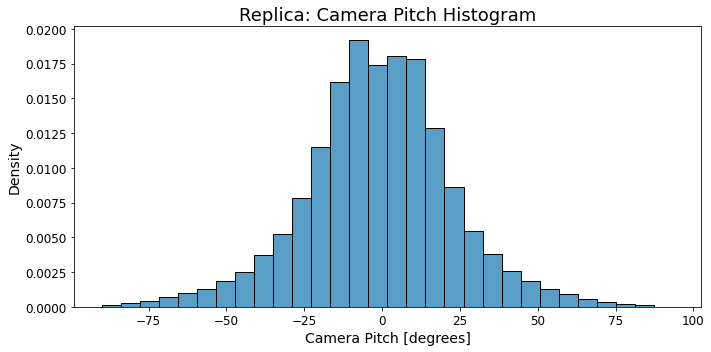

In [84]:
plot_camera_pitch(stats_dict, 'replica', combine=False)
plot_camera_pitch(stats_dict, 'replica', combine=True)

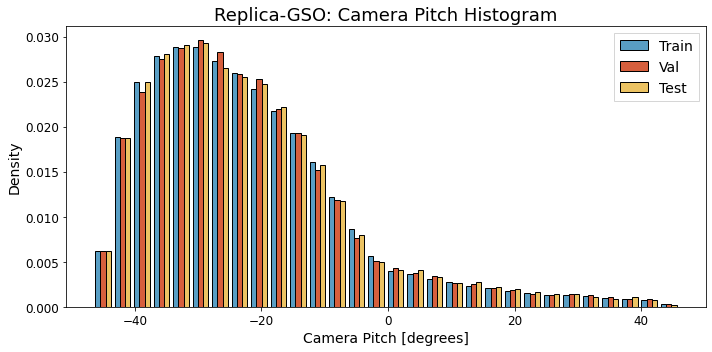

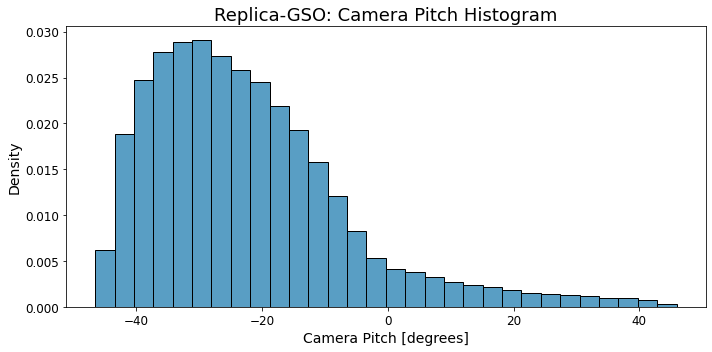

In [85]:
plot_camera_pitch(stats_dict, 'gso', combine=False)
plot_camera_pitch(stats_dict, 'gso', combine=True)

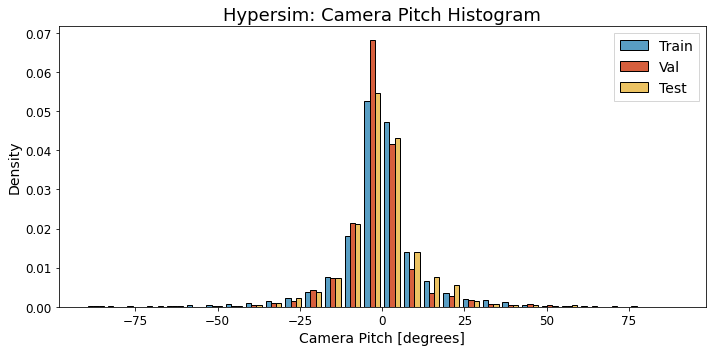

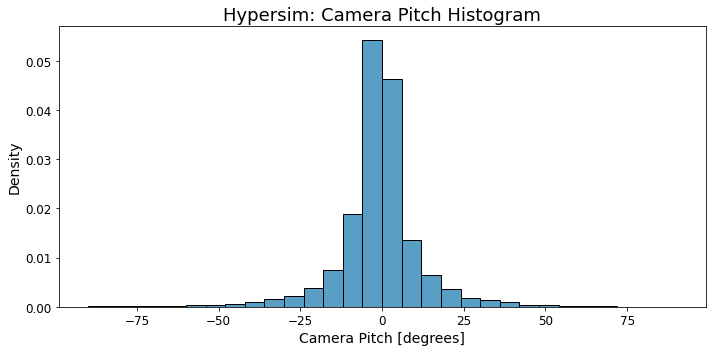

In [86]:
plot_camera_pitch(stats_dict, 'hypersim', combine=False)
plot_camera_pitch(stats_dict, 'hypersim', combine=True)

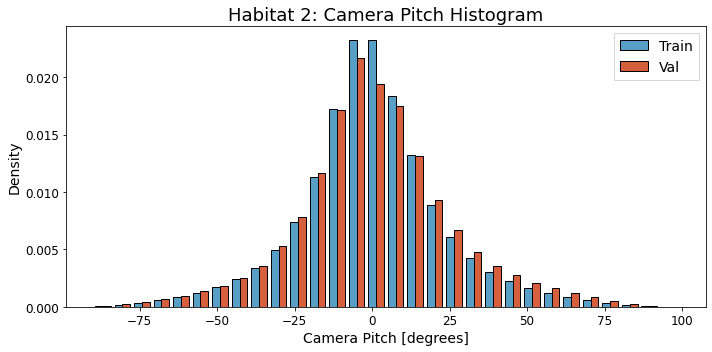

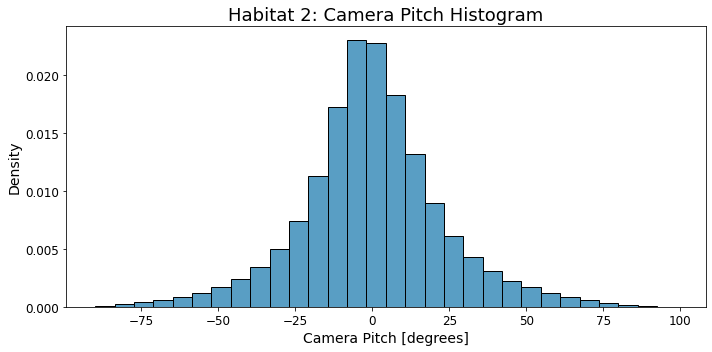

In [87]:
plot_camera_pitch(stats_dict, 'habitat2', combine=False)
plot_camera_pitch(stats_dict, 'habitat2', combine=True)

### 2.2 Camera Roll

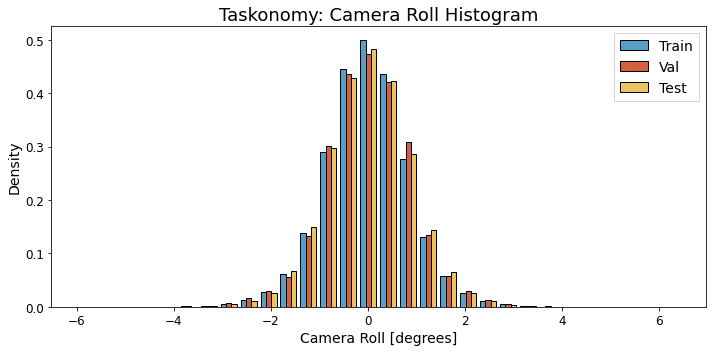

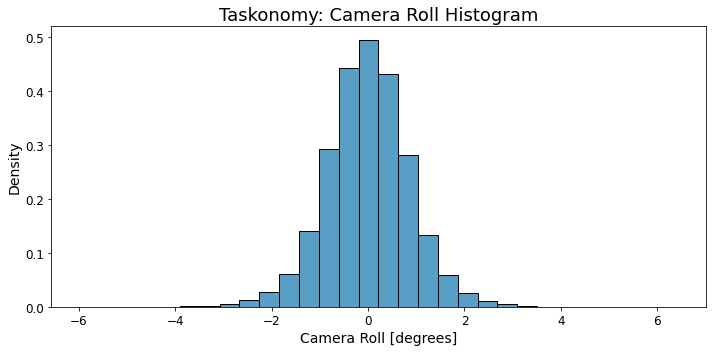

In [88]:
plot_camera_roll(stats_dict, 'taskonomy', combine=False)
plot_camera_roll(stats_dict, 'taskonomy', combine=True)

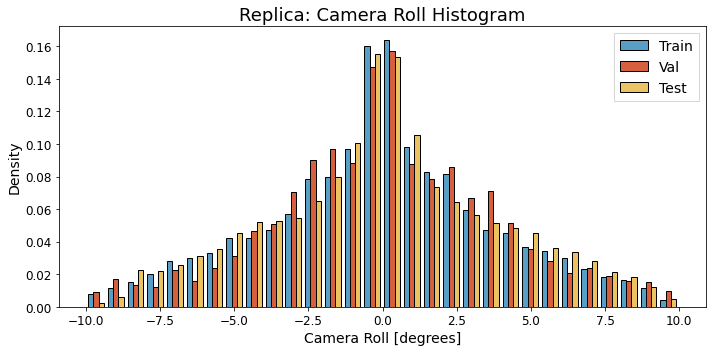

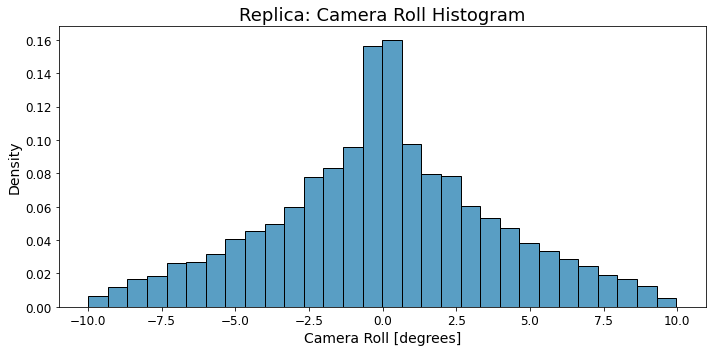

In [89]:
plot_camera_roll(stats_dict, 'replica', combine=False)
plot_camera_roll(stats_dict, 'replica', combine=True)

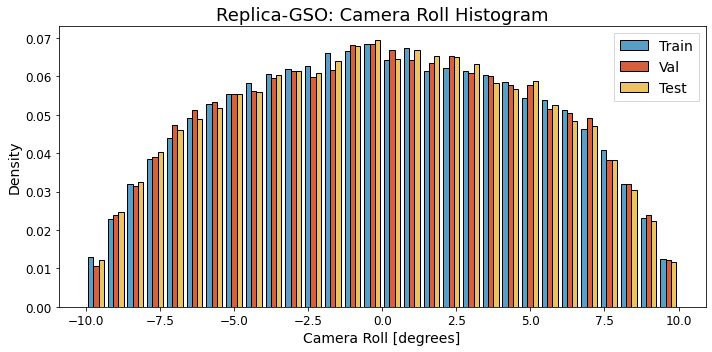

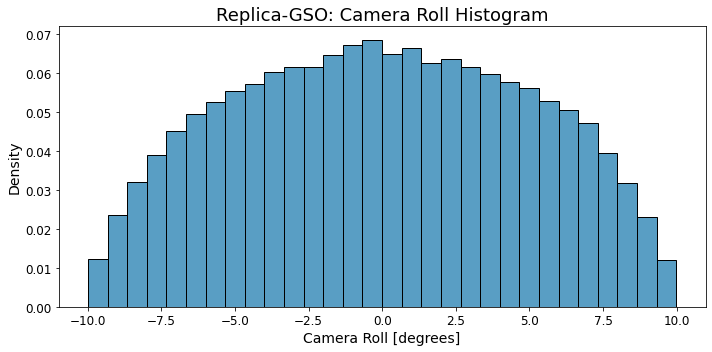

In [90]:
plot_camera_roll(stats_dict, 'gso', combine=False)
plot_camera_roll(stats_dict, 'gso', combine=True)

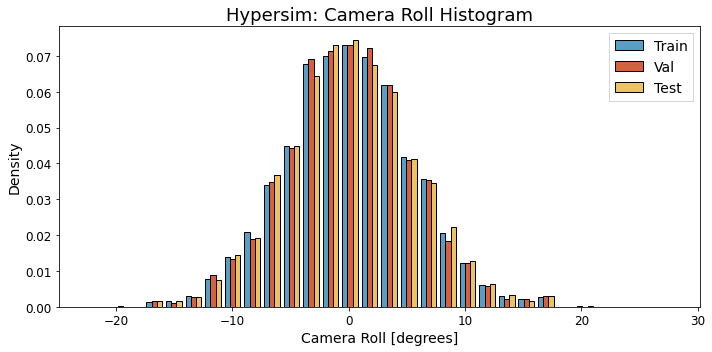

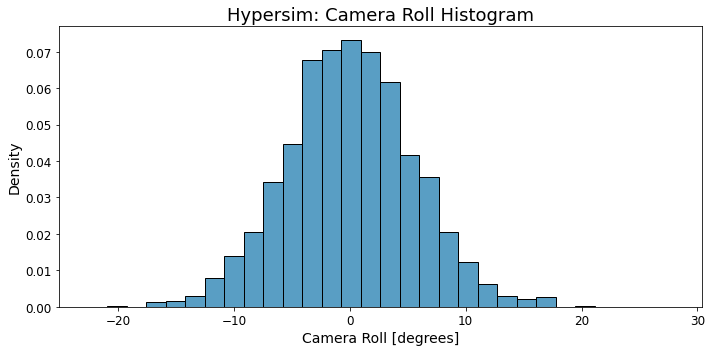

In [91]:
plot_camera_roll(stats_dict, 'hypersim', combine=False)
plot_camera_roll(stats_dict, 'hypersim', combine=True)

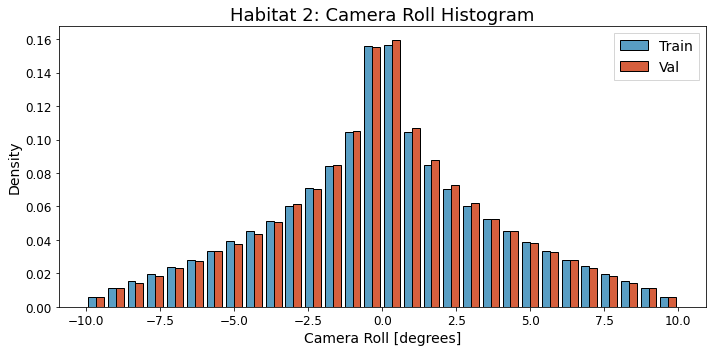

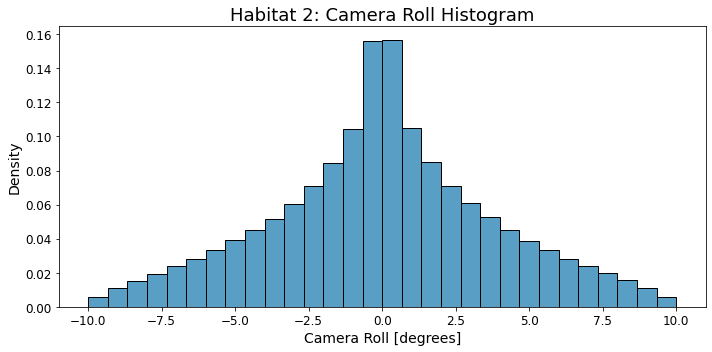

In [92]:
plot_camera_roll(stats_dict, 'habitat2', combine=False)
plot_camera_roll(stats_dict, 'habitat2', combine=True)

### 2.3 Camera FoV (vertical)

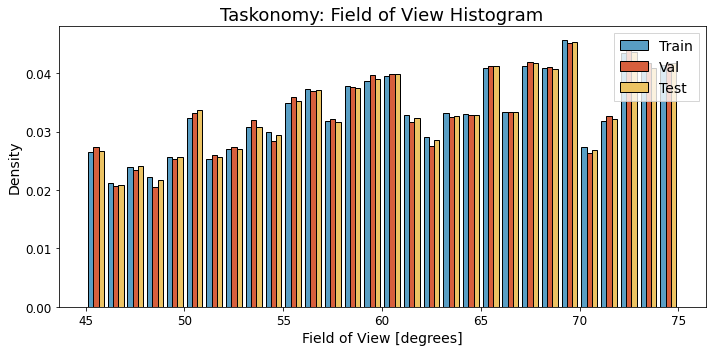

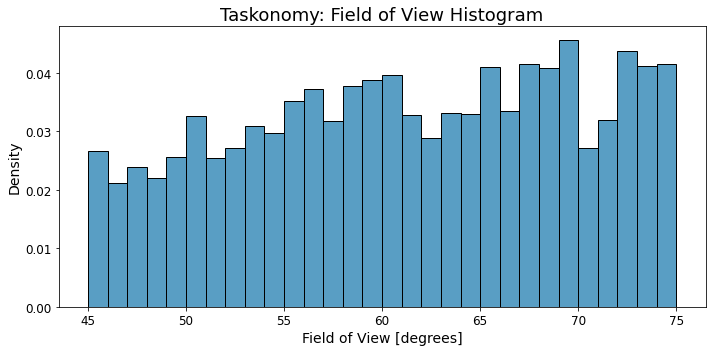

In [93]:
plot_fovs(stats_dict, 'taskonomy', combine=False)
plot_fovs(stats_dict, 'taskonomy', combine=True)

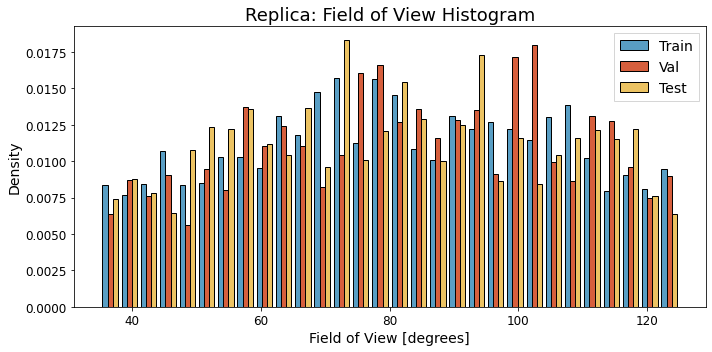

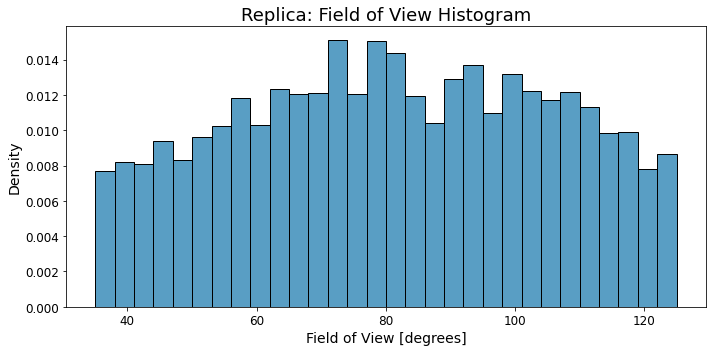

In [94]:
plot_fovs(stats_dict, 'replica', combine=False)
plot_fovs(stats_dict, 'replica', combine=True)

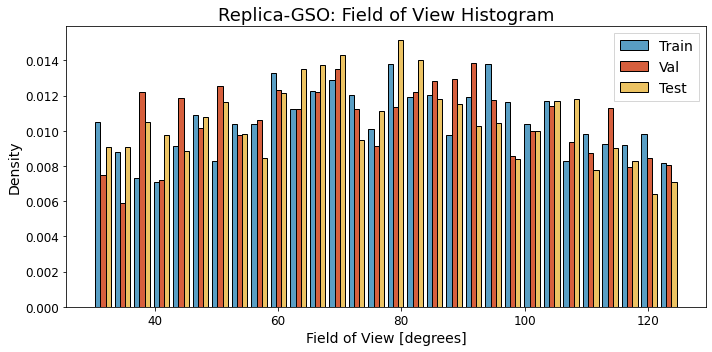

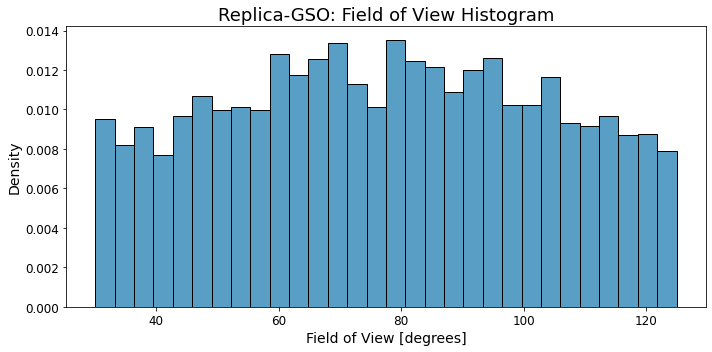

In [95]:
plot_fovs(stats_dict, 'gso', combine=False)
plot_fovs(stats_dict, 'gso', combine=True)

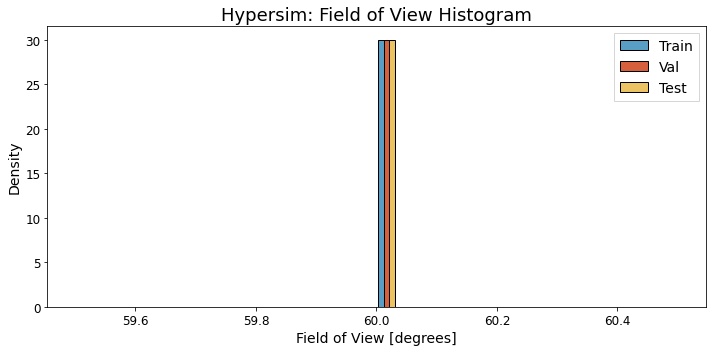

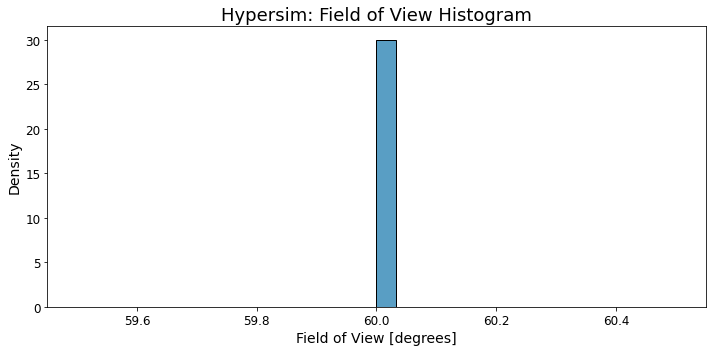

In [96]:
plot_fovs(stats_dict, 'hypersim', combine=False)
plot_fovs(stats_dict, 'hypersim', combine=True)

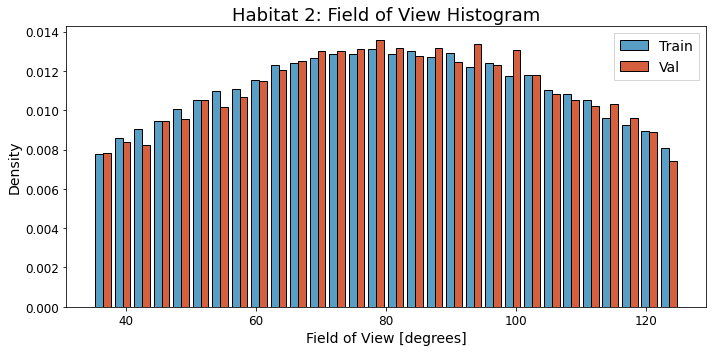

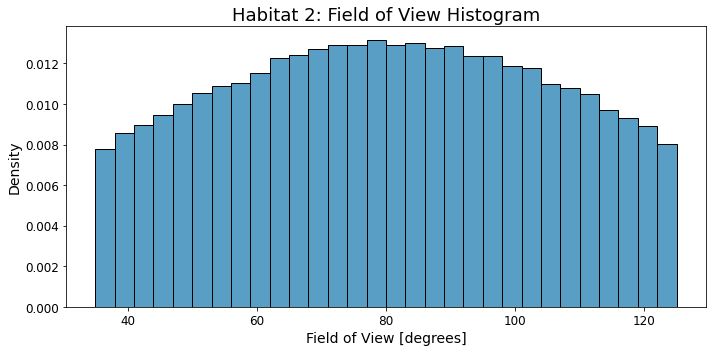

In [97]:
plot_fovs(stats_dict, 'habitat2', combine=False)
plot_fovs(stats_dict, 'habitat2', combine=True)

### 2.4 Distances

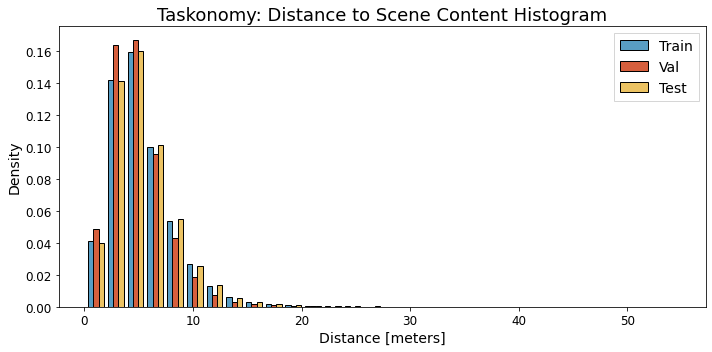

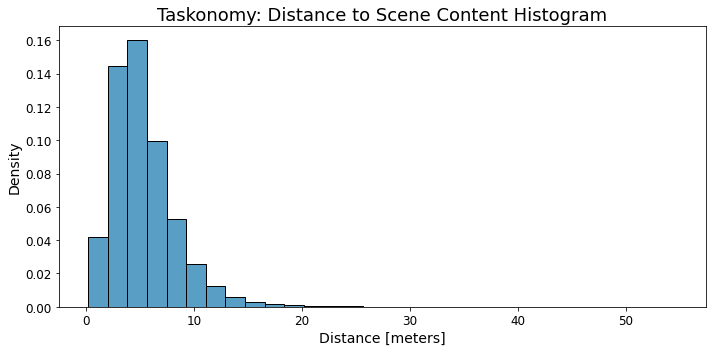

In [98]:
plot_distances(stats_dict, 'taskonomy', combine=False)
plot_distances(stats_dict, 'taskonomy', combine=True)

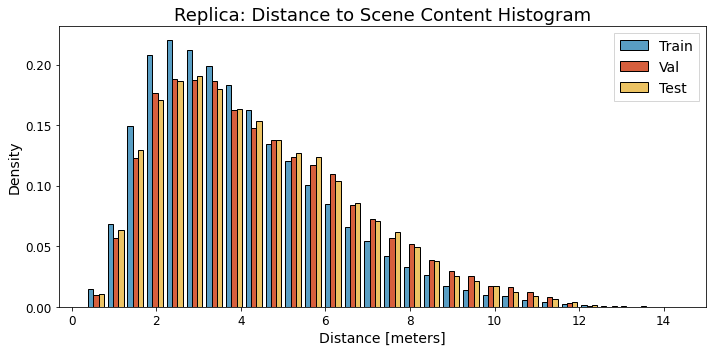

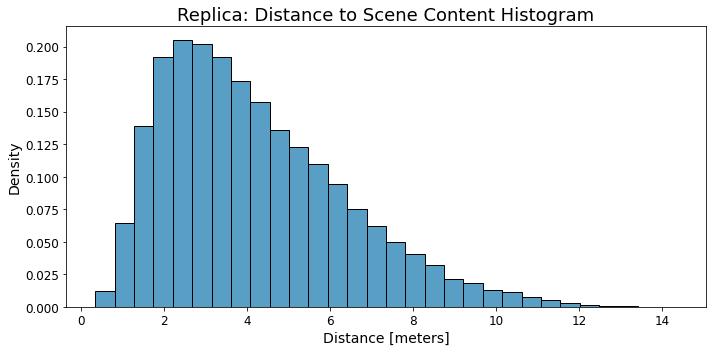

In [99]:
plot_distances(stats_dict, 'replica', combine=False)
plot_distances(stats_dict, 'replica', combine=True)

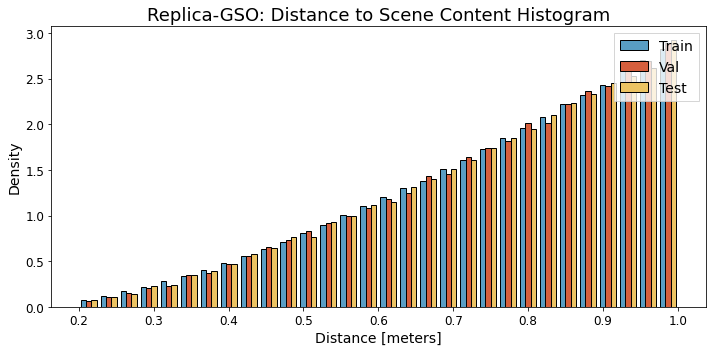

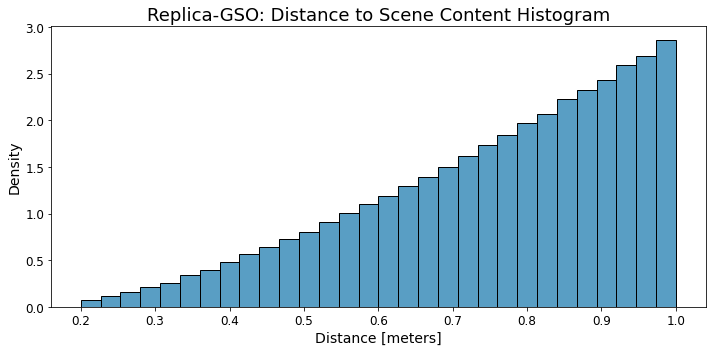

In [100]:
plot_distances(stats_dict, 'gso', combine=False)
plot_distances(stats_dict, 'gso', combine=True)

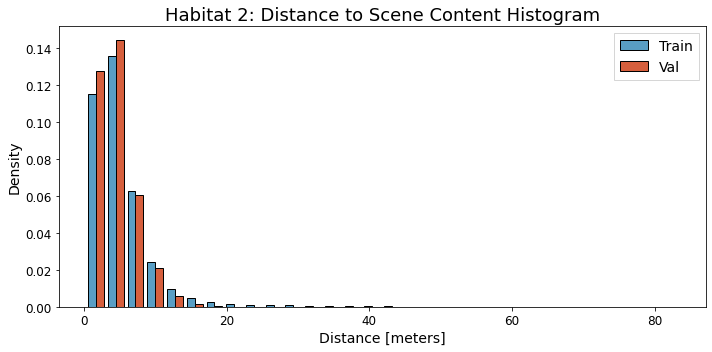

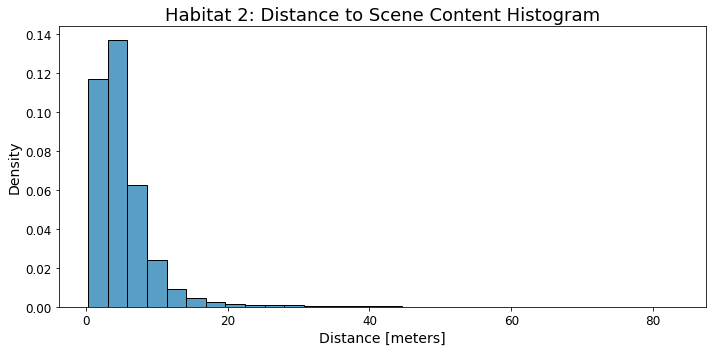

In [101]:
plot_distances(stats_dict, 'habitat2', combine=False)
plot_distances(stats_dict, 'habitat2', combine=True)

### 2.5 Obliqueness Angles

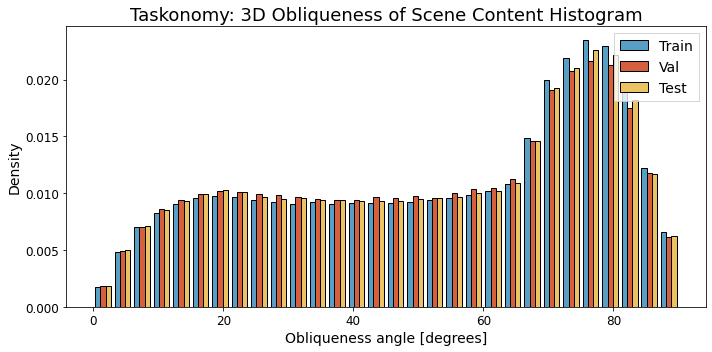

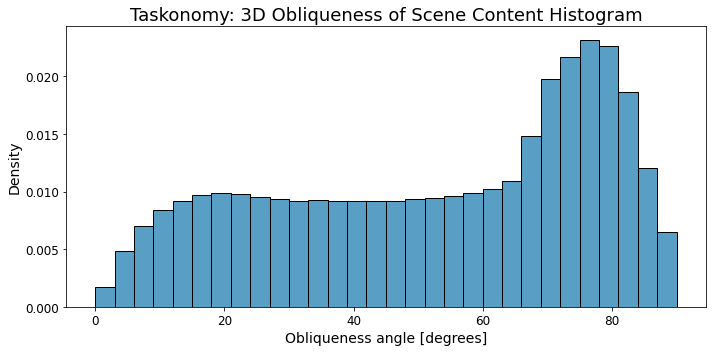

In [102]:
plot_obliqueness_angles(stats_dict, 'taskonomy', combine=False)
plot_obliqueness_angles(stats_dict, 'taskonomy', combine=True)

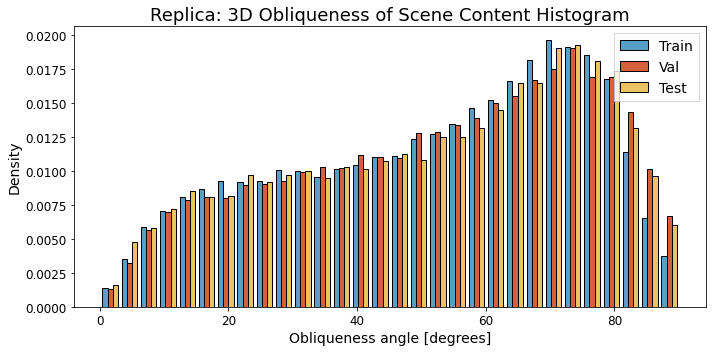

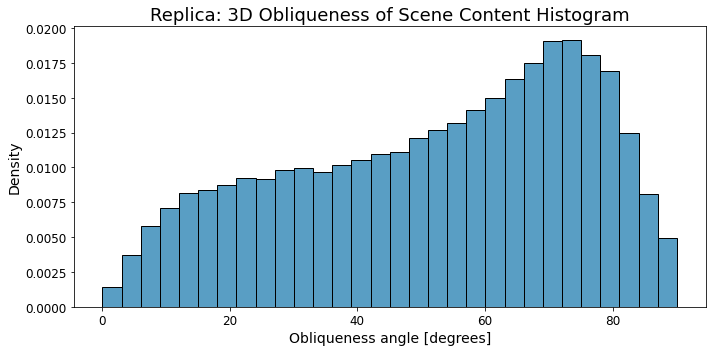

In [103]:
plot_obliqueness_angles(stats_dict, 'replica', combine=False)
plot_obliqueness_angles(stats_dict, 'replica', combine=True)

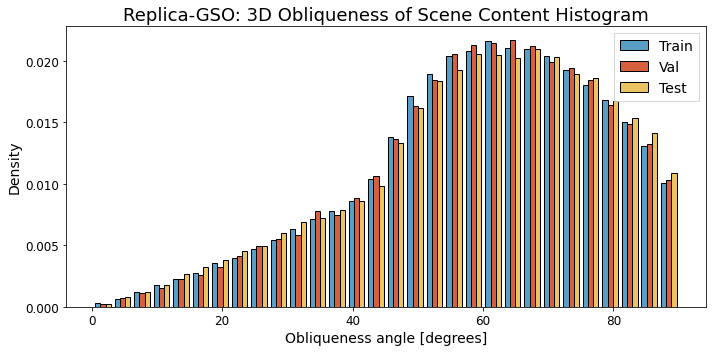

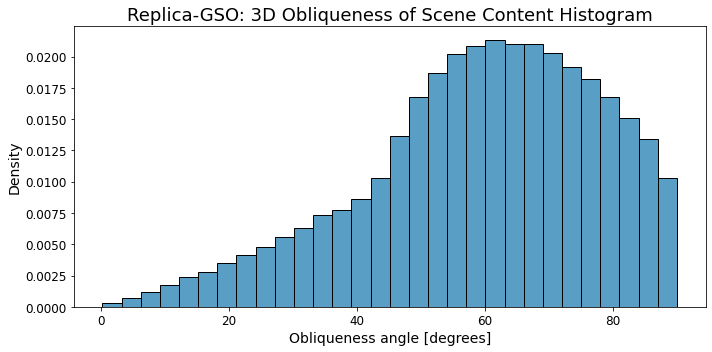

In [104]:
plot_obliqueness_angles(stats_dict, 'gso', combine=False)
plot_obliqueness_angles(stats_dict, 'gso', combine=True)

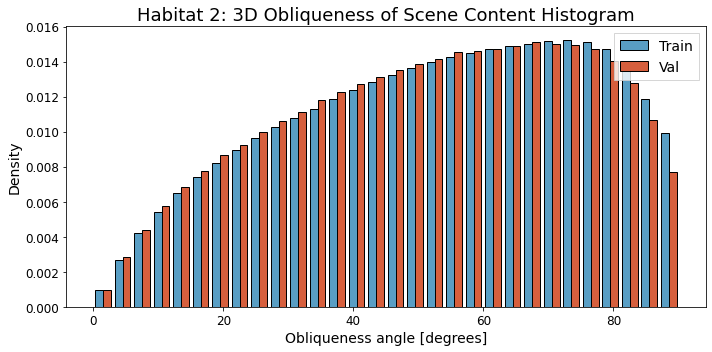

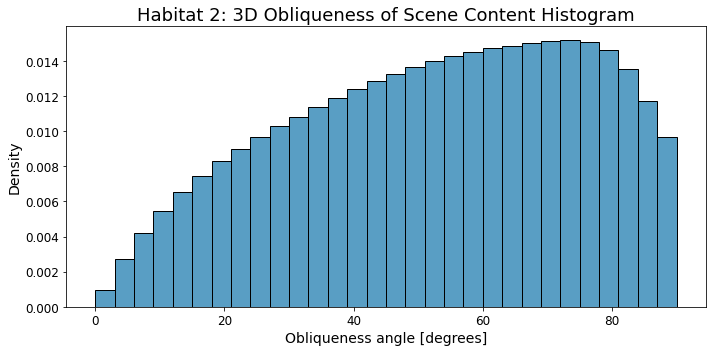

In [105]:
plot_obliqueness_angles(stats_dict, 'habitat2', combine=False)
plot_obliqueness_angles(stats_dict, 'habitat2', combine=True)

### 2.6 Number of views per point

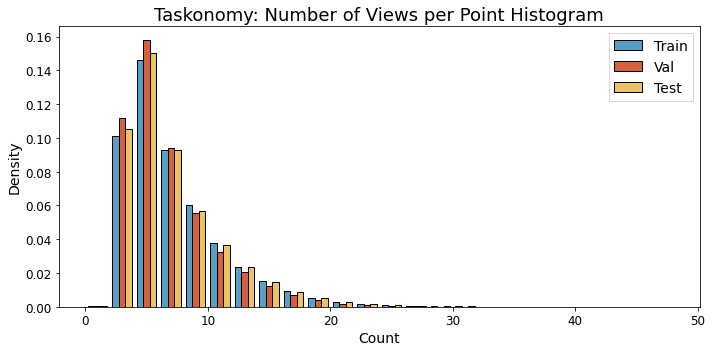

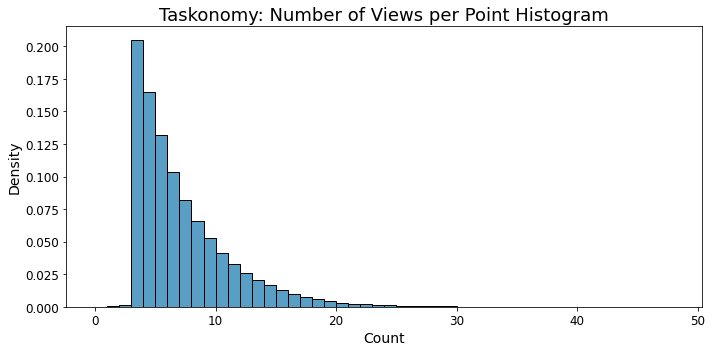

In [106]:
plot_views_per_point(stats_dict, 'taskonomy', combine=False)
plot_views_per_point(stats_dict, 'taskonomy', combine=True)

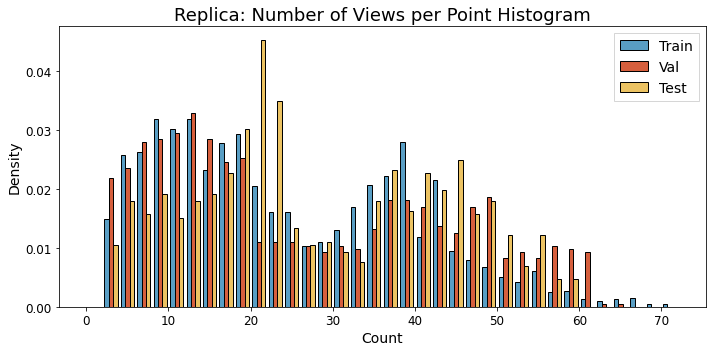

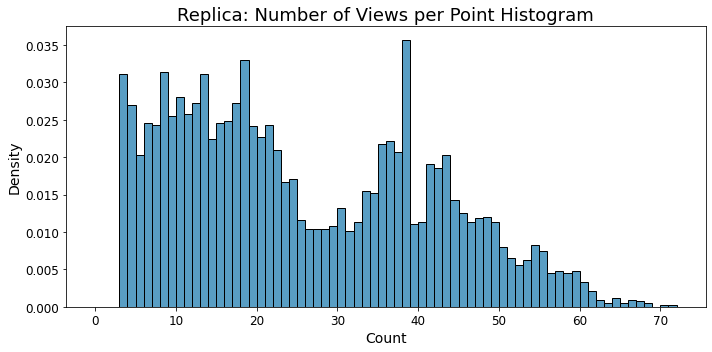

In [107]:
plot_views_per_point(stats_dict, 'replica', combine=False)
plot_views_per_point(stats_dict, 'replica', combine=True)

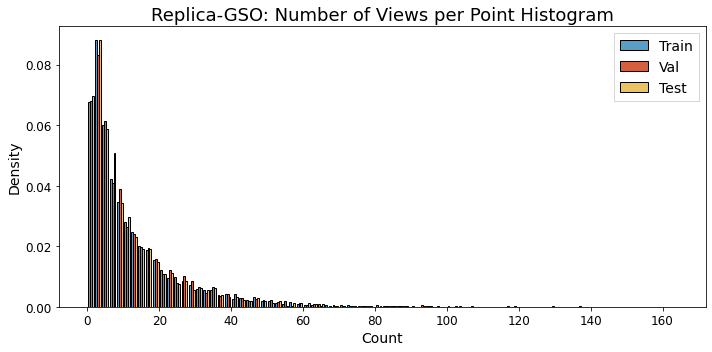

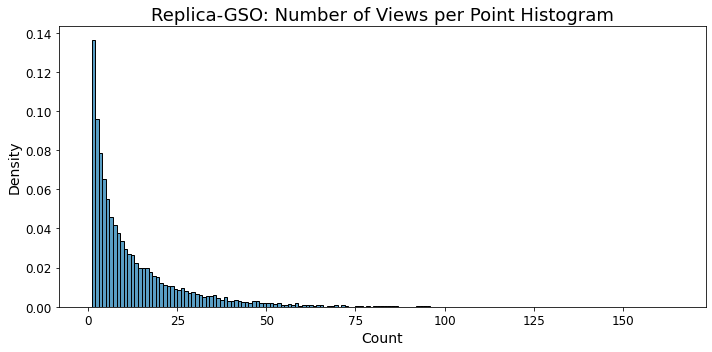

In [108]:
plot_views_per_point(stats_dict, 'gso', combine=False)
plot_views_per_point(stats_dict, 'gso', combine=True)

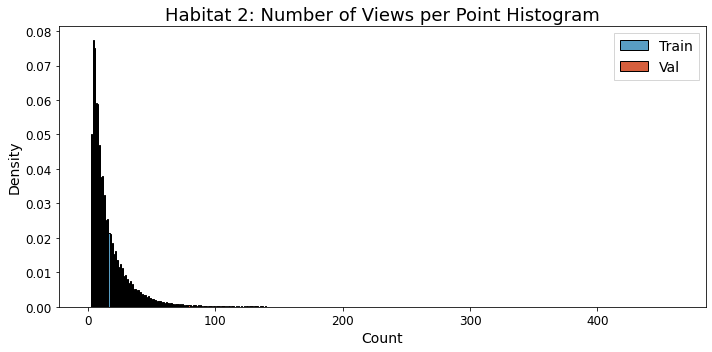

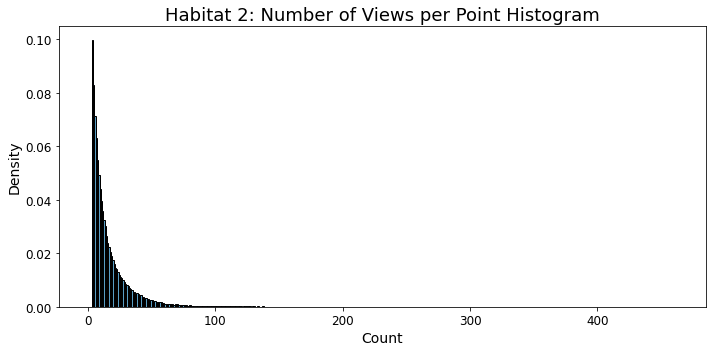

In [109]:
plot_views_per_point(stats_dict, 'habitat2', combine=False)
plot_views_per_point(stats_dict, 'habitat2', combine=True)

### 2.7 Number of non-fixated points per "camera point" (i.e. total over all camera views)

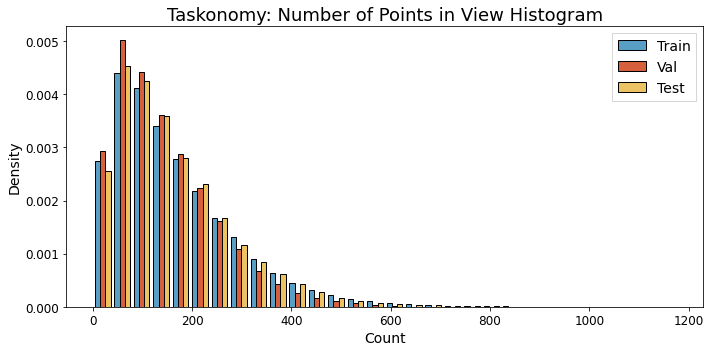

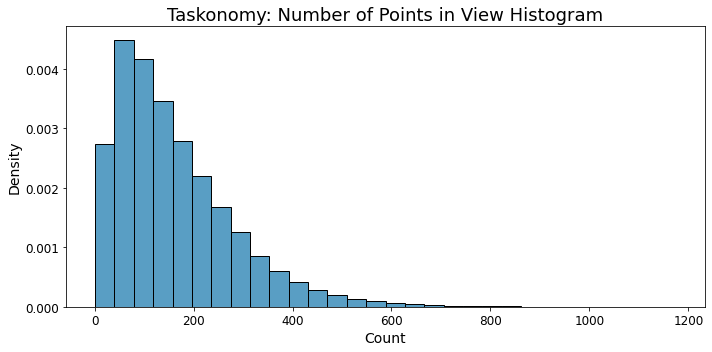

In [110]:
plot_points_per_camera(stats_dict, 'taskonomy', combine=False)
plot_points_per_camera(stats_dict, 'taskonomy', combine=True)

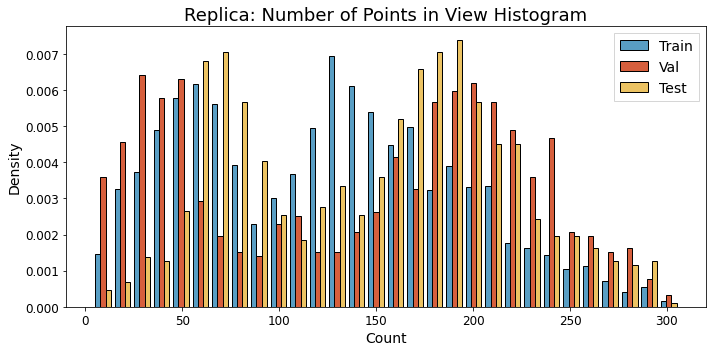

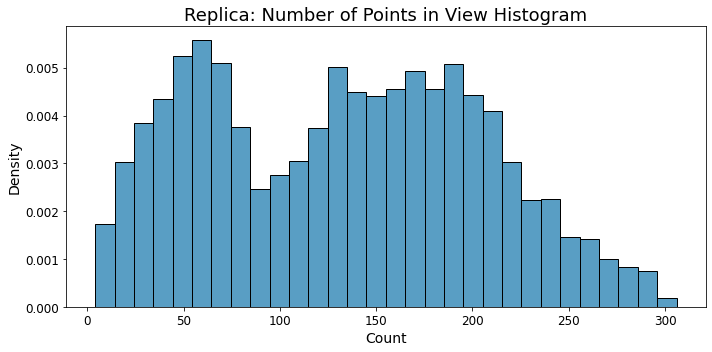

In [111]:
plot_points_per_camera(stats_dict, 'replica', combine=False)
plot_points_per_camera(stats_dict, 'replica', combine=True)

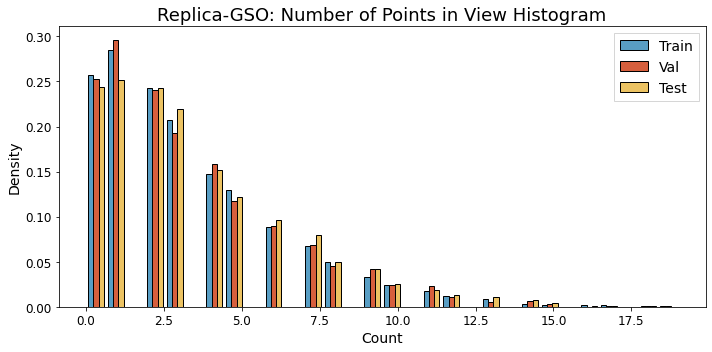

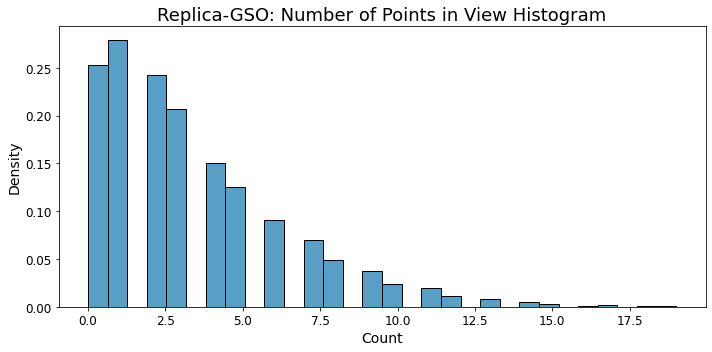

In [112]:
plot_points_per_camera(stats_dict, 'gso', combine=False)
plot_points_per_camera(stats_dict, 'gso', combine=True)

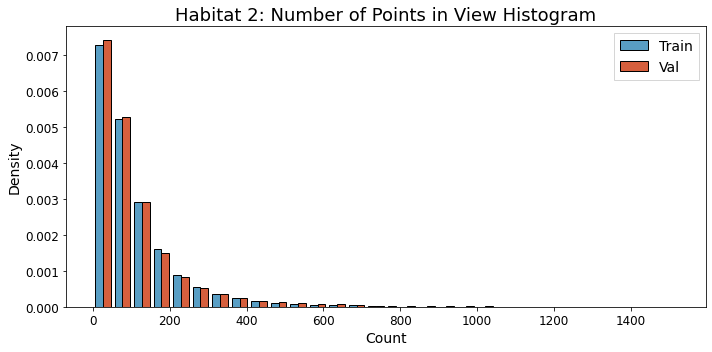

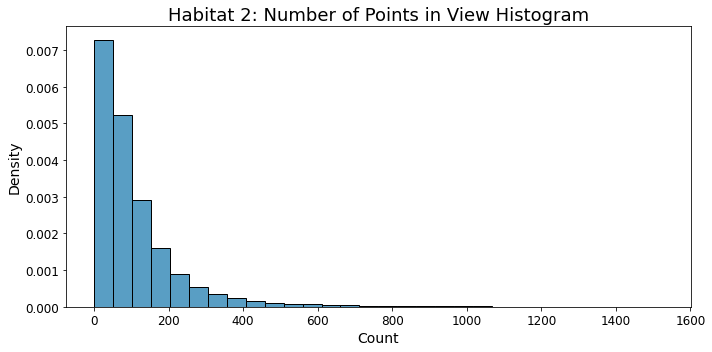

In [113]:
plot_points_per_camera(stats_dict, 'habitat2', combine=False)
plot_points_per_camera(stats_dict, 'habitat2', combine=True)

## 3 Full histograms in one plot

In [154]:
def plot_hist_ax(ax, train_list, val_list, test_list, bins,
                 xlabel=None, ylabel=None, title=None):
    hist_lists, hist_labels, hist_colors = [], [], []
    if len(train_list) > 0:
        hist_lists.append(train_list)
        hist_labels.append('Train')
        hist_colors.append(COLORS[0])
    if len(val_list) > 0:
        hist_lists.append(val_list)
        hist_labels.append('Val')
        hist_colors.append(COLORS[1])
    if len(test_list) > 0:
        hist_lists.append(test_list)
        hist_labels.append('Test')
        hist_colors.append(COLORS[2])
    ax.hist(hist_lists, bins=bins, density=True, 
            label=hist_labels, color=hist_colors, edgecolor='black')
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=24, labelpad=10)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=18)
    if title is not None:
        ax.set_title(title, fontsize=34, pad=30)
    ax.tick_params(axis='both', labelsize=16)

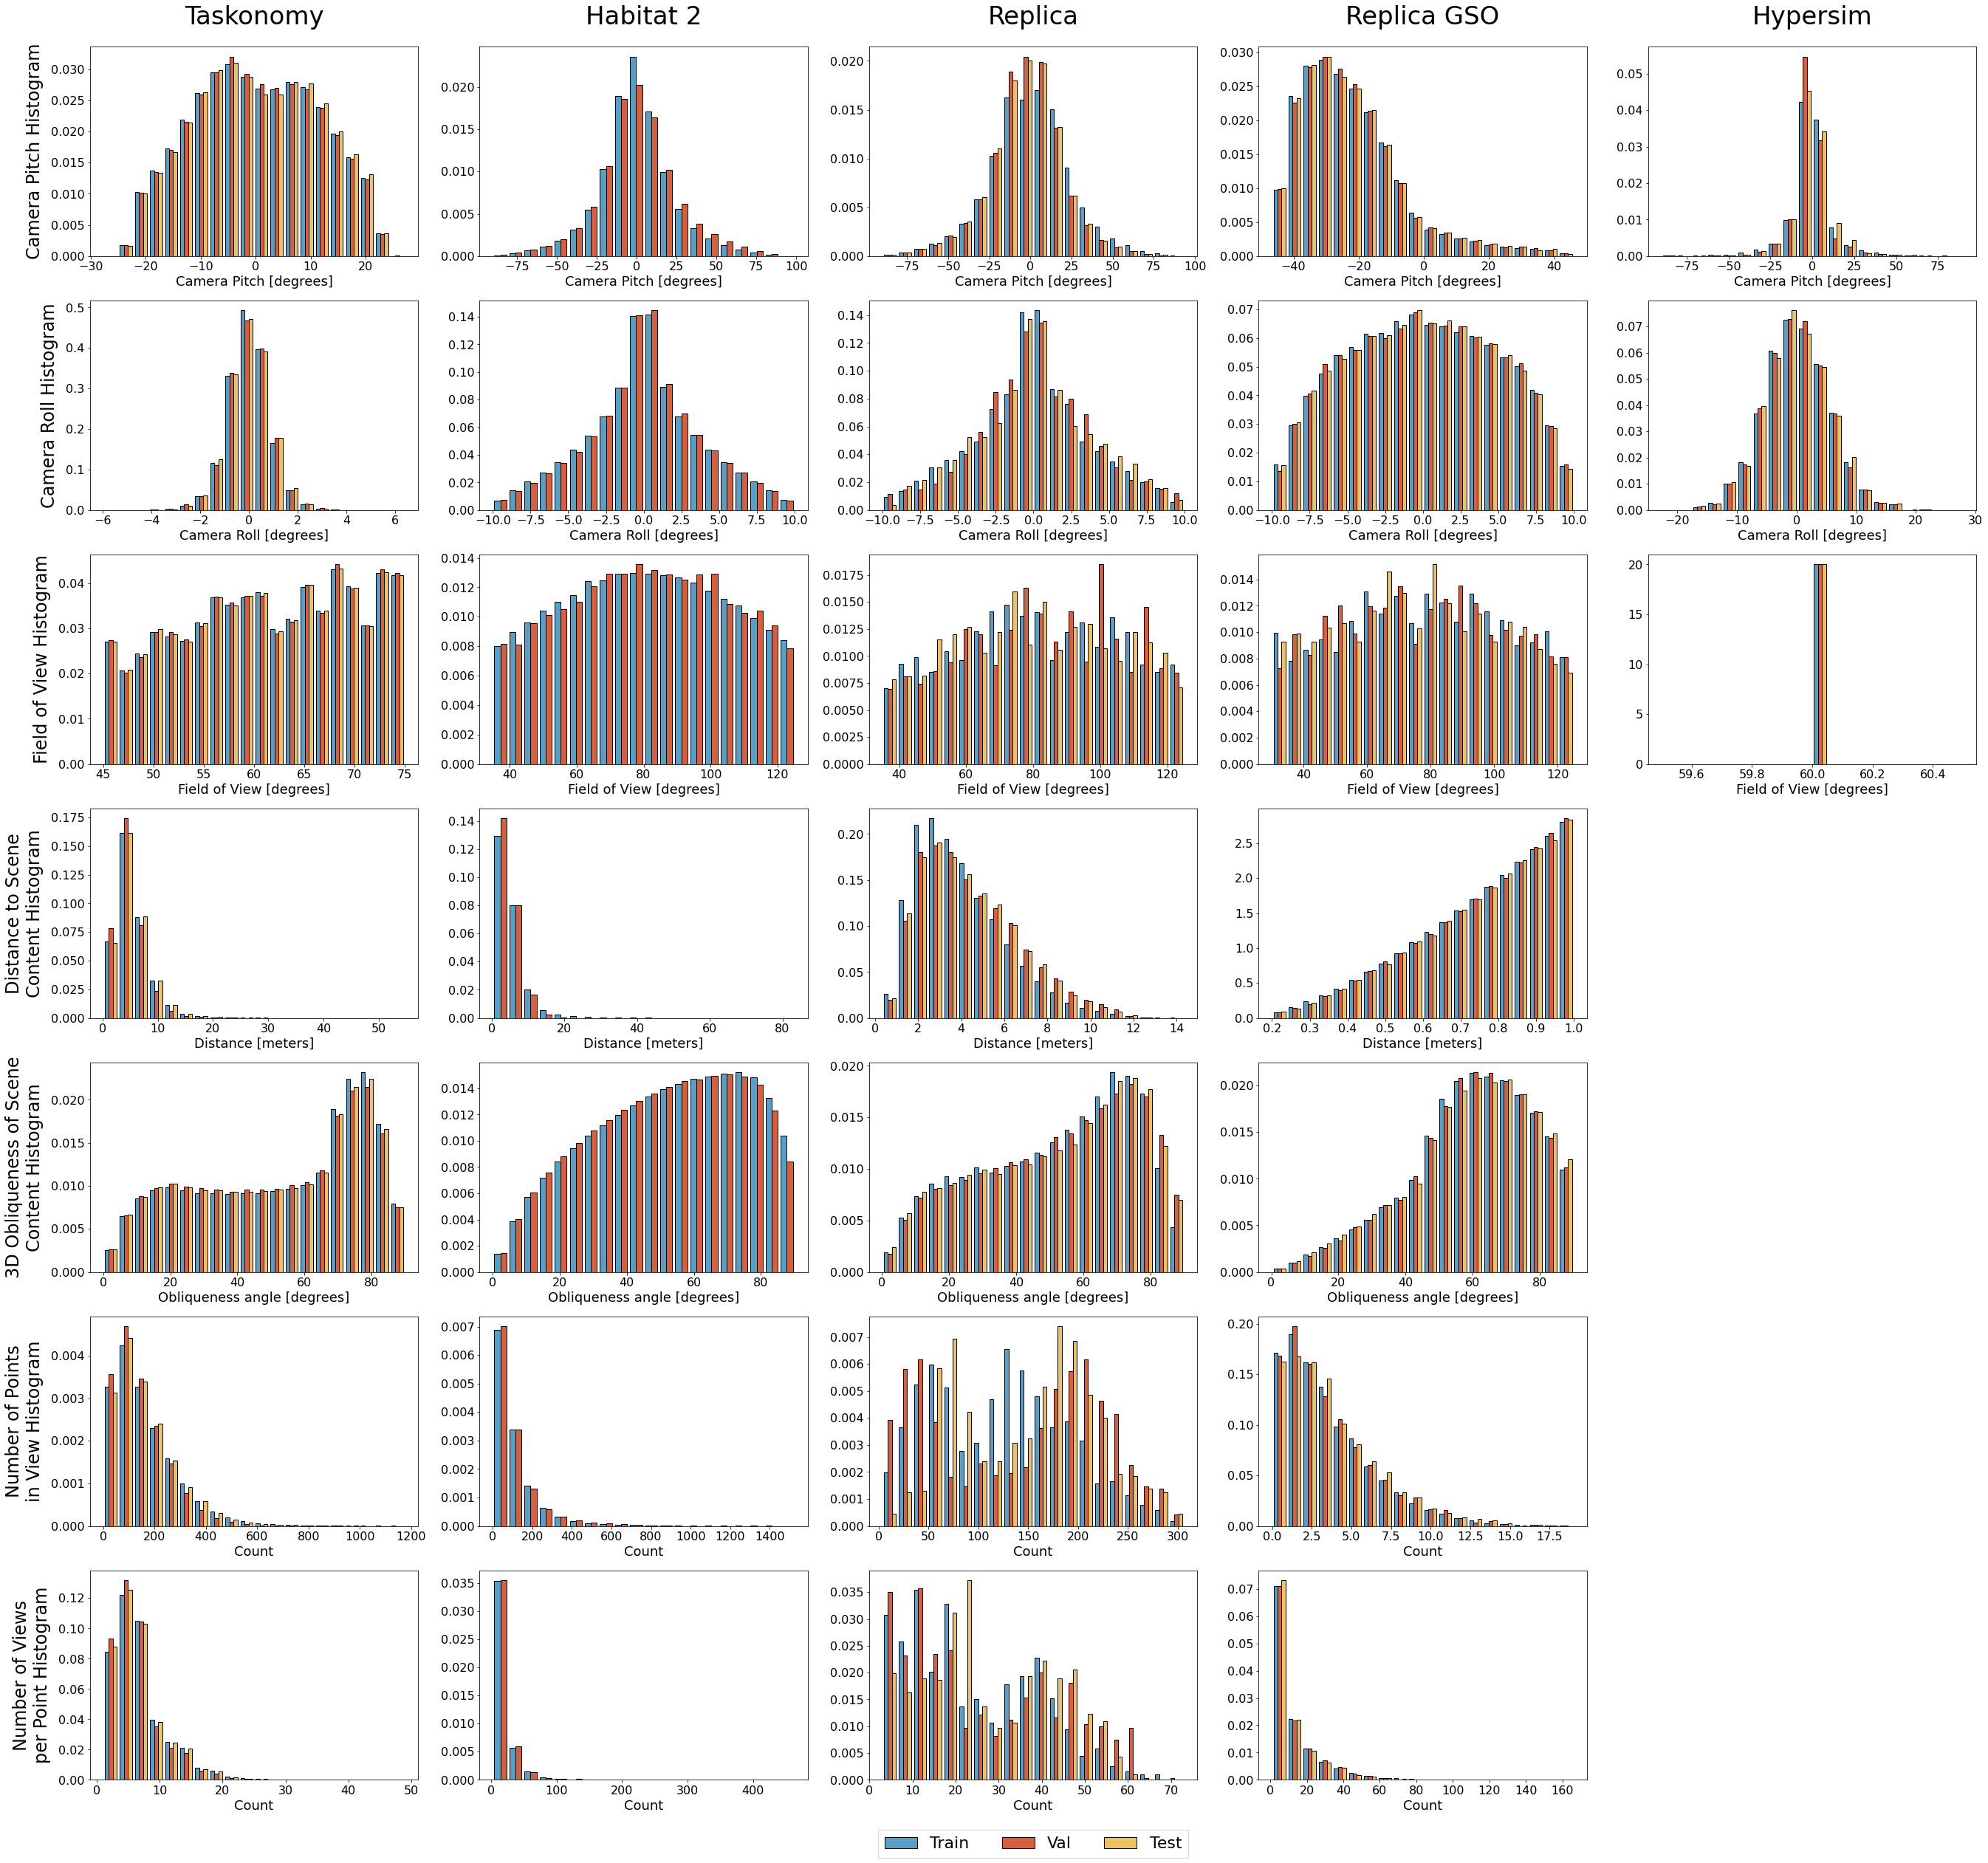

In [155]:
nrows = 7
ncols = 5
figscale = 5.0

idx_taskonomy = 0
idx_habitat = 1
idx_replica = 2
idx_gso = 3
idx_hypersim = 4


fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5*ncols*figscale, nrows*figscale))

### Pitch ###
row_idx = 0
xlabel = 'Camera Pitch [degrees]'
ylabel = 'Camera Pitch Histogram'
fn = get_camera_pitch
bins = 20

train_list, val_list, test_list = fn(stats_dict, 'taskonomy')
plot_hist_ax(
    ax[row_idx,idx_taskonomy], train_list, val_list, test_list, bins=bins, 
    xlabel=xlabel, ylabel=ylabel, title='Taskonomy'
)
train_list, val_list, test_list = fn(stats_dict, 'habitat2')
plot_hist_ax(
    ax[row_idx,idx_habitat], train_list, val_list, test_list, bins=bins, 
    xlabel=xlabel, title='Habitat 2'
)
train_list, val_list, test_list = fn(stats_dict, 'replica')
plot_hist_ax(
    ax[row_idx,idx_replica], train_list, val_list, test_list, bins=bins, 
    xlabel=xlabel, title='Replica'
)
train_list, val_list, test_list = fn(stats_dict, 'gso')
plot_hist_ax(
    ax[row_idx,idx_gso], train_list, val_list, test_list, bins=bins, 
    xlabel=xlabel, title='Replica GSO'
)
train_list, val_list, test_list = fn(stats_dict, 'hypersim')
plot_hist_ax(
    ax[row_idx,idx_hypersim], train_list, val_list, test_list, bins=bins, 
    xlabel=xlabel, title='Hypersim'
)


### Roll ###
row_idx = 1
xlabel = 'Camera Roll [degrees]'
ylabel = 'Camera Roll Histogram'
fn = get_camera_roll
bins = 20

train_list, val_list, test_list = fn(stats_dict, 'taskonomy')
plot_hist_ax(ax[row_idx,idx_taskonomy], train_list, val_list, test_list, bins=bins, xlabel=xlabel, ylabel=ylabel)
train_list, val_list, test_list = fn(stats_dict, 'habitat2')
plot_hist_ax(ax[row_idx,idx_habitat], train_list, val_list, test_list, bins=bins, xlabel=xlabel)
train_list, val_list, test_list = fn(stats_dict, 'replica')
plot_hist_ax(ax[row_idx,idx_replica], train_list, val_list, test_list, bins=bins, xlabel=xlabel)
train_list, val_list, test_list = fn(stats_dict, 'gso')
plot_hist_ax(ax[row_idx,idx_gso], train_list, val_list, test_list, bins=bins, xlabel=xlabel)
train_list, val_list, test_list = fn(stats_dict, 'hypersim')
plot_hist_ax(ax[row_idx,idx_hypersim], train_list, val_list, test_list, bins=bins, xlabel=xlabel)


### FoV ###
row_idx = 2
xlabel = 'Field of View [degrees]'
ylabel = 'Field of View Histogram'
fn = get_fovs
bins = 20

train_list, val_list, test_list = fn(stats_dict, 'taskonomy')
plot_hist_ax(ax[row_idx,idx_taskonomy], train_list, val_list, test_list, bins=bins, xlabel=xlabel, ylabel=ylabel)
train_list, val_list, test_list = fn(stats_dict, 'habitat2')
plot_hist_ax(ax[row_idx,idx_habitat], train_list, val_list, test_list, bins=bins, xlabel=xlabel)
train_list, val_list, test_list = fn(stats_dict, 'replica')
plot_hist_ax(ax[row_idx,idx_replica], train_list, val_list, test_list, bins=bins, xlabel=xlabel)
train_list, val_list, test_list = fn(stats_dict, 'gso')
plot_hist_ax(ax[row_idx,idx_gso], train_list, val_list, test_list, bins=bins, xlabel=xlabel)
train_list, val_list, test_list = fn(stats_dict, 'hypersim')
plot_hist_ax(ax[row_idx,idx_hypersim], train_list, val_list, test_list, bins=bins, xlabel=xlabel)


### FoV ###
row_idx = 3
xlabel = 'Distance [meters]'
ylabel = 'Distance to Scene\nContent Histogram'
fn = get_distances
bins = 20

train_list, val_list, test_list = fn(stats_dict, 'taskonomy')
plot_hist_ax(ax[row_idx,idx_taskonomy], train_list, val_list, test_list, bins=bins, xlabel=xlabel, ylabel=ylabel)
train_list, val_list, test_list = fn(stats_dict, 'habitat2')
plot_hist_ax(ax[row_idx,idx_habitat], train_list, val_list, test_list, bins=bins, xlabel=xlabel)
train_list, val_list, test_list = fn(stats_dict, 'replica')
plot_hist_ax(ax[row_idx,idx_replica], train_list, val_list, test_list, bins=bins, xlabel=xlabel)
train_list, val_list, test_list = fn(stats_dict, 'gso')
plot_hist_ax(ax[row_idx,idx_gso], train_list, val_list, test_list, bins=bins, xlabel=xlabel)
ax[row_idx,idx_hypersim].axis('off')

### Obliqueness angle ###
row_idx = 4
xlabel = 'Obliqueness angle [degrees]'
ylabel = '3D Obliqueness of Scene\nContent Histogram'
fn = get_obliqueness_angles
bins = 20

train_list, val_list, test_list = fn(stats_dict, 'taskonomy')
plot_hist_ax(ax[row_idx,idx_taskonomy], train_list, val_list, test_list, bins=bins, xlabel=xlabel, ylabel=ylabel)
train_list, val_list, test_list = fn(stats_dict, 'habitat2')
plot_hist_ax(ax[row_idx,idx_habitat], train_list, val_list, test_list, bins=bins, xlabel=xlabel)
train_list, val_list, test_list = fn(stats_dict, 'replica')
plot_hist_ax(ax[row_idx,idx_replica], train_list, val_list, test_list, bins=bins, xlabel=xlabel)
train_list, val_list, test_list = fn(stats_dict, 'gso')
plot_hist_ax(ax[row_idx,idx_gso], train_list, val_list, test_list, bins=bins, xlabel=xlabel)
ax[row_idx,idx_hypersim].axis('off')

### Points per camera ###
row_idx = 5
xlabel = 'Count'
ylabel = 'Number of Points\nin View Histogram'
fn = get_points_per_camera
bins = 20

train_list, val_list, test_list = fn(stats_dict, 'taskonomy')
plot_hist_ax(ax[row_idx,idx_taskonomy], train_list, val_list, test_list, bins=bins, xlabel=xlabel, ylabel=ylabel)
train_list, val_list, test_list = fn(stats_dict, 'habitat2')
plot_hist_ax(ax[row_idx,idx_habitat], train_list, val_list, test_list, bins=bins, xlabel=xlabel)
train_list, val_list, test_list = fn(stats_dict, 'replica')
plot_hist_ax(ax[row_idx,idx_replica], train_list, val_list, test_list, bins=bins, xlabel=xlabel)
train_list, val_list, test_list = fn(stats_dict, 'gso')
plot_hist_ax(ax[row_idx,idx_gso], train_list, val_list, test_list, bins=bins, xlabel=xlabel)
ax[row_idx,idx_hypersim].axis('off')

### Views per Point ###
row_idx = 6
xlabel = 'Count'
ylabel = 'Number of Views\nper Point Histogram'
fn = get_views_per_point
bins = 20

train_list, val_list, test_list = fn(stats_dict, 'taskonomy')
plot_hist_ax(ax[row_idx,idx_taskonomy], train_list, val_list, test_list, bins=bins, xlabel=xlabel, ylabel=ylabel)
train_list, val_list, test_list = fn(stats_dict, 'habitat2')
plot_hist_ax(ax[row_idx,idx_habitat], train_list, val_list, test_list, bins=bins, xlabel=xlabel)
train_list, val_list, test_list = fn(stats_dict, 'replica')
plot_hist_ax(ax[row_idx,idx_replica], train_list, val_list, test_list, bins=bins, xlabel=xlabel)
train_list, val_list, test_list = fn(stats_dict, 'gso')
plot_hist_ax(ax[row_idx,idx_gso], train_list, val_list, test_list, bins=bins, xlabel=xlabel)
ax[row_idx,idx_hypersim].axis('off')

legend_elements = [Patch(facecolor=COLORS[0], edgecolor='black', label='Train'),
                   Patch(facecolor=COLORS[1], edgecolor='black', label='Val'),
                   Patch(facecolor=COLORS[2], edgecolor='black', label='Test')]
ax[row_idx,idx_replica].legend(handles=legend_elements, fontsize=22, fancybox=False, loc='upper center', ncol=3, bbox_to_anchor=(0.5,-0.2))

plt.tight_layout()
plt.savefig('./omnidata_hist_train_val_test.pdf')
plt.show()

## 4 Histogram comparison between datasets

In [213]:
COLORS_D = ['#599ec4', '#d65f3d', '#ecc363', '#704C5E', '#629460']

In [254]:
def get_agg_stats_and_kde(fn, domains=['taskonomy', 'habitat2', 'replica', 'gso', 'hypersim']):
    all_stats = [reduce(lambda x,y: x+y, fn(stats_dict, domain)) for domain in domains]
    
    min_val = min(map(min, all_stats))
    max_val = max(map(max, all_stats))
    xx = np.linspace(min_val, max_val, 100)
    all_kde = [gaussian_kde(data_stats)(xx) for data_stats in all_stats]
    
    return all_stats, all_kde, xx

all_stats_pitch, all_kde_pitch, xx_pitch = get_agg_stats_and_kde(get_camera_pitch, domains=['taskonomy', 'habitat2', 'replica', 'gso', 'hypersim'])
all_stats_roll, all_kde_roll, xx_roll = get_agg_stats_and_kde(get_camera_roll, domains=['taskonomy', 'habitat2', 'replica', 'gso', 'hypersim'])
all_stats_fov, all_kde_fov, xx_fov = get_agg_stats_and_kde(get_fovs, domains=['taskonomy', 'habitat2', 'replica', 'gso', 'hypersim'])
all_stats_dist, all_kde_dist, xx_dist = get_agg_stats_and_kde(get_distances, domains=['taskonomy', 'habitat2', 'replica', 'gso'])
all_stats_obliq, all_kde_obliq, xx_obliq = get_agg_stats_and_kde(get_obliqueness_angles, domains=['taskonomy', 'habitat2', 'replica', 'gso'])
all_stats_pv, all_kde_pv, xx_pv = get_agg_stats_and_kde(get_points_per_camera, domains=['taskonomy', 'habitat2', 'replica', 'gso'])
all_stats_vp, all_kde_vp, xx_vp = get_agg_stats_and_kde(get_views_per_point, domains=['taskonomy', 'habitat2', 'replica', 'gso'])

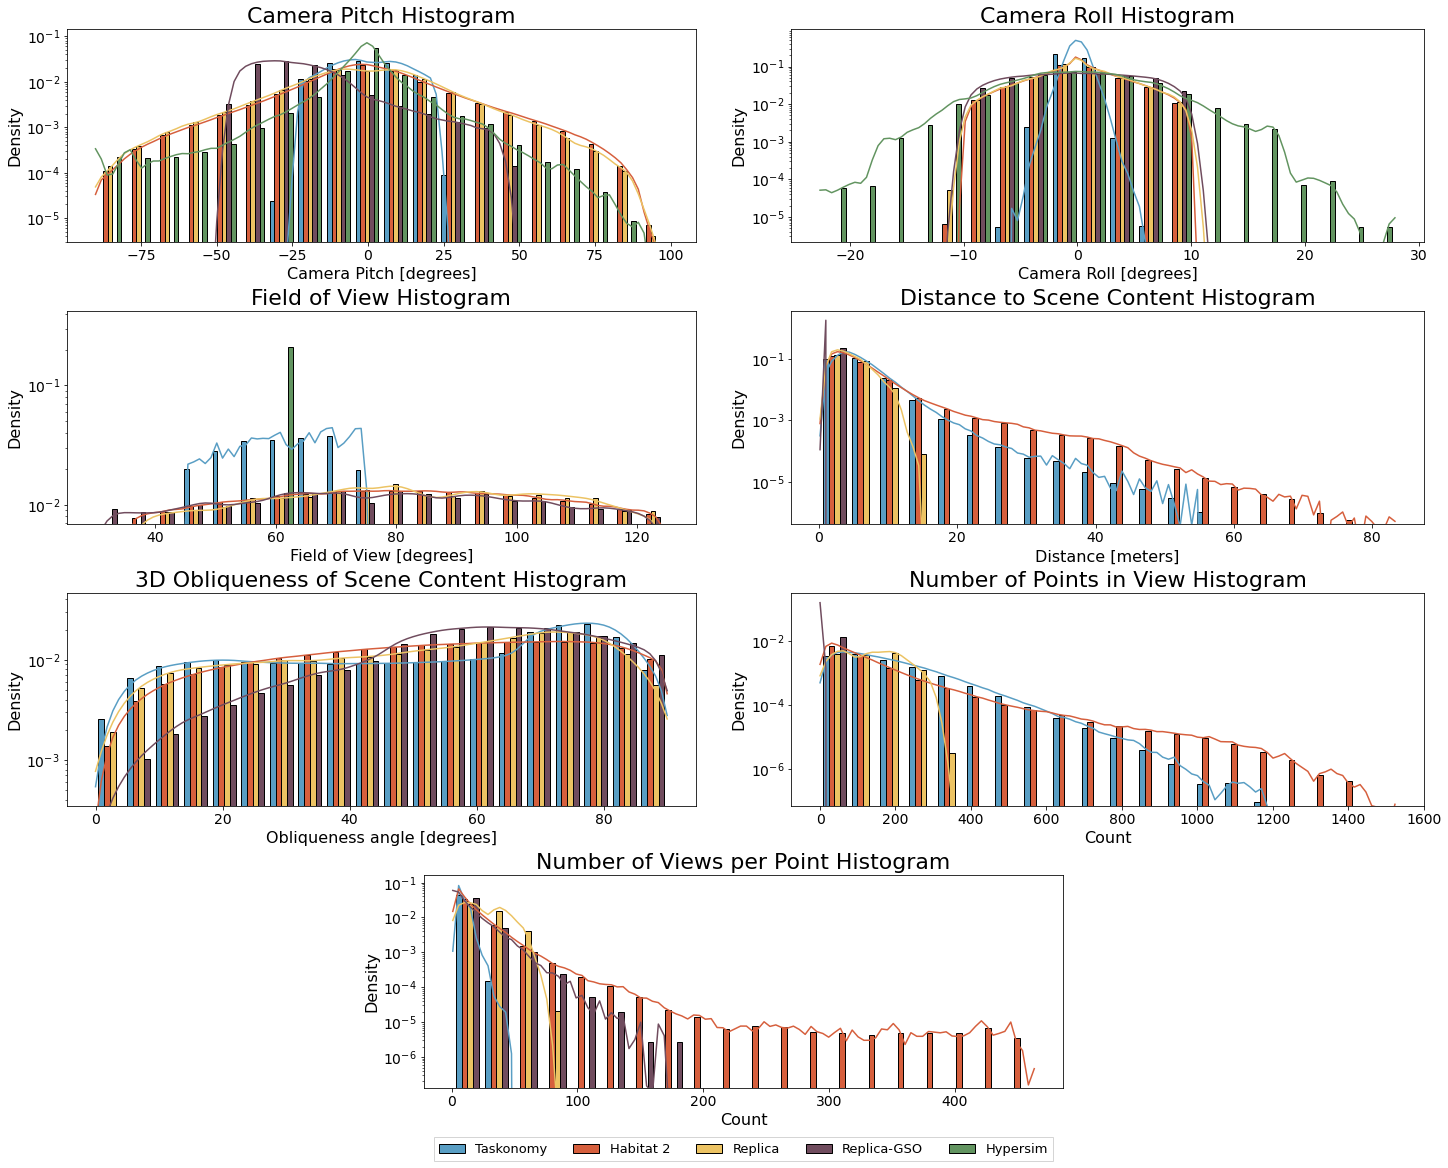

In [315]:
title_size = 22
xlabel_size = 16
ticks_size = 14
yscale = 'log'
plot_kde = True
bins = 20

fig = plt.figure(constrained_layout=True, figsize=(20,25))
gs = fig.add_gridspec(7, 4)


# Pitch
ax0 = fig.add_subplot(gs[0,:2])
d,_,_ = ax0.hist(all_stats_pitch, density=True, bins=bins, edgecolor='black', color=COLORS_D)
if plot_kde:
    for idx, kde in enumerate(all_kde_pitch):
        ax0.plot(xx_pitch, kde, color=COLORS_D[idx])
ax0.set_xlabel('Camera Pitch [degrees]', fontsize=xlabel_size)
ax0.set_ylabel('Density', fontsize=xlabel_size)
ax0.set_title('Camera Pitch Histogram', fontsize=title_size)
ax0.set_yscale(yscale)
ax0.set_ylim([d[d>0].min(), 2*max(d.max(), max(map(max, all_kde_pitch)))])
ax0.tick_params(axis='both', labelsize=ticks_size)


# Roll
ax1 = fig.add_subplot(gs[0,2:])
d,_,_ = ax1.hist(all_stats_roll, density=True, bins=bins, edgecolor='black', color=COLORS_D)
if plot_kde:
    for idx, kde in enumerate(all_kde_roll):
        ax1.plot(xx_roll, kde, color=COLORS_D[idx])
ax1.set_xlabel('Camera Roll [degrees]', fontsize=xlabel_size)
ax1.set_ylabel('Density', fontsize=xlabel_size)
ax1.set_title('Camera Roll Histogram', fontsize=title_size)
ax1.set_yscale(yscale)
ax1.set_ylim([d[d>0].min(), 2*max(d.max(), max(map(max, all_kde_roll)))])
ax1.tick_params(axis='both', labelsize=ticks_size)


# FoV
ax2 = fig.add_subplot(gs[1,:2])
d,_,_ = ax2.hist(all_stats_fov, density=True, bins=bins, edgecolor='black', color=COLORS_D)
if plot_kde:
    for idx, kde in enumerate(all_kde_fov):
        ax2.plot(xx_fov, kde, color=COLORS_D[idx])
ax2.set_xlabel('Field of View [degrees]', fontsize=xlabel_size)
ax2.set_ylabel('Density', fontsize=xlabel_size)
ax2.set_title('Field of View Histogram', fontsize=title_size)
ax2.set_yscale(yscale)
ax2.set_ylim([d[d>0].min(), 2*max(d.max(), max(map(max, all_kde_fov)))])
ax2.tick_params(axis='both', labelsize=ticks_size)


# Distance
ax3 = fig.add_subplot(gs[1,2:])
d,_,_ = ax3.hist(all_stats_dist, density=True, bins=bins, edgecolor='black', color=COLORS_D[:4])
if plot_kde:
    for idx, kde in enumerate(all_kde_dist):
        ax3.plot(xx_dist, kde, color=COLORS_D[idx])
ax3.set_xlabel('Distance [meters]', fontsize=xlabel_size)
ax3.set_ylabel('Density', fontsize=xlabel_size)
ax3.set_title('Distance to Scene Content Histogram', fontsize=title_size)
ax3.set_yscale(yscale)
ax3.set_ylim([d[d>0].min(), 2*max(d.max(), max(map(max, all_kde_dist)))])
ax3.tick_params(axis='both', labelsize=ticks_size)


# Obliqueness angle
ax4 = fig.add_subplot(gs[2,:2])
d,_,_ = ax4.hist(all_stats_obliq, density=True, bins=bins, edgecolor='black', color=COLORS_D[:4])
if plot_kde:
    for idx, kde in enumerate(all_kde_obliq):
        ax4.plot(xx_obliq, kde, color=COLORS_D[idx])
ax4.set_xlabel('Obliqueness angle [degrees]', fontsize=xlabel_size)
ax4.set_ylabel('Density', fontsize=xlabel_size)
ax4.set_title('3D Obliqueness of Scene Content Histogram', fontsize=title_size)
ax4.set_yscale(yscale)
ax4.set_ylim([d[d>0].min(), 2*max(d.max(), max(map(max, all_kde_obliq)))])
ax4.tick_params(axis='both', labelsize=ticks_size)


# Points in View
ax5 = fig.add_subplot(gs[2,2:])
d,_,_ = ax5.hist(all_stats_pv, density=True, bins=bins, edgecolor='black', color=COLORS_D[:4])
if plot_kde:
    for idx, kde in enumerate(all_kde_pv):
        ax5.plot(xx_pv, kde, color=COLORS_D[idx])
ax5.set_xlabel('Count', fontsize=xlabel_size)
ax5.set_ylabel('Density', fontsize=xlabel_size)
ax5.set_title('Number of Points in View Histogram', fontsize=title_size)
ax5.set_yscale(yscale)
ax5.set_ylim([d[d>0].min(), 2*max(d.max(), max(map(max, all_kde_pv)))])
ax5.tick_params(axis='both', labelsize=ticks_size)


# Views per Point
ax6 = fig.add_subplot(gs[3,1:3])
d,_,_ = ax6.hist(all_stats_vp, density=True, bins=bins, edgecolor='black', color=COLORS_D[:4])
if plot_kde:
    for idx, kde in enumerate(all_kde_vp):
        ax6.plot(xx_vp, kde, color=COLORS_D[idx])
ax6.set_xlabel('Count', fontsize=xlabel_size)
ax6.set_ylabel('Density', fontsize=xlabel_size)
ax6.set_title('Number of Views per Point Histogram', fontsize=title_size)
ax6.set_yscale(yscale)
ax6.set_ylim([d[d>0].min(), 2*max(d.max(), max(map(max, all_kde_vp)))])
ax6.tick_params(axis='both', labelsize=ticks_size)


# Legend
legend_elements = [Patch(facecolor=COLORS_D[0], edgecolor='black', label='Taskonomy'),
                   Patch(facecolor=COLORS_D[1], edgecolor='black', label='Habitat 2'),
                   Patch(facecolor=COLORS_D[2], edgecolor='black', label='Replica'),
                   Patch(facecolor=COLORS_D[3], edgecolor='black', label='Replica-GSO'),
                   Patch(facecolor=COLORS_D[4], edgecolor='black', label='Hypersim')]
ax6.legend(handles=legend_elements, fontsize=13, fancybox=False, loc='upper center', ncol=5, bbox_to_anchor=(0.5,-0.2))

plt.savefig('./omnidata_hist_combined.pdf')
plt.show()